In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time  # 시간 측정을 위한 모듈
from tqdm import tqdm
import os
from sklearn.metrics import r2_score


In [3]:
##### train.csv 전처리
data_train = pd.read_csv('train.csv',encoding='euc-kr')

# DataFrame 생성
df_train = pd.DataFrame(data_train)

# date_time에서 시간 추출
df_train['hour'] = pd.to_datetime(df_train['date_time']).dt.hour

# 시간대에 따른 time 변수 생성 (0~5 -> 0, 6~11 -> 1, 12~17 -> 2, 18~23 -> 3)
df_train['time'] = pd.cut(df_train['hour'], bins=[-1, 5, 11, 17, 23], labels=[0, 1, 2, 3])

# date_time 열 삭제, hour 열 삭제
df_train.drop(columns = ['date_time'],inplace = True)
df_train.drop(columns = ['hour'],inplace = True)
# 결과 확인
print(df_train.isna().sum())
df_train

num           0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
time          0
dtype: int64


,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,0
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,0
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,0
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,3
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,3
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,3
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,3


In [4]:
##### test.csv 전처리
data_test = pd.read_csv('test.csv',encoding='euc-kr')
df_test = pd.DataFrame(data_test)

# 비전기냉방설비운영 열과 태양광보유 열 결측치 처리
num_list = df_test['num'].drop_duplicates().values

for i in num_list:
    if df_test.loc[(df_test['num'] == i) & (df_test['date_time'] == '2020-08-25 00'), '비전기냉방설비운영'].isna().any():
        # 조건에 맞는 값이 결측치일 때 0으로 수정
        df_test.loc[df_test['num'] == i, '비전기냉방설비운영'] = 0
    else:
        # 조건에 맞는 값이 결측치가 아닐 때 1로 수정
        df_test.loc[df_test['num'] == i, '비전기냉방설비운영'] = 1


for i in num_list:
    if df_test.loc[(df_test['num'] == i) & (df_test['date_time'] == '2020-08-25 00'), '비전기냉방설비운영'].isna().any():
        # 조건에 맞는 값이 결측치일 때 0으로 수정
        df_test.loc[df_test['num'] == i, '태양광보유'] = 0
    else:
        # 조건에 맞는 값이 결측치가 아닐 때 1로 수정
        df_test.loc[df_test['num'] == i, '태양광보유'] = 1
''' # 확인하는 코드
for i in num_list:
    print(f'{i} : ', df_test.loc[df_test['num']== i,'비전기냉방설비운영'].value_counts())
for i in num_list:
    print(f'{i} : ', df_test.loc[df_test['num']== i,'태양광보유'].value_counts())
'''


# date_time에서 시간 추출
df_test['hour'] = pd.to_datetime(df_test['date_time']).dt.hour

# 시간대에 따른 time 변수 생성 (0~5 -> 0, 6~11 -> 1, 12~17 -> 2, 18~23 -> 3)
df_test['time'] = pd.cut(df_test['hour'], bins=[-1, 5, 11, 17, 23], labels=[0, 1, 2, 3])

# 'date_time'을 인덱스로 설정
df_test['date_time'] = pd.to_datetime(df_test['date_time'])
df_test.set_index('date_time', inplace=True)

# Time-based Interpolation
df_test['기온(°C)'] = df_test['기온(°C)'].interpolate(method='time')
df_test['풍속(m/s)'] = df_test['풍속(m/s)'].interpolate(method='time')
df_test['습도(%)'] = df_test['습도(%)'].interpolate(method='time')
df_test['강수량(mm, 6시간)'] = df_test['강수량(mm, 6시간)'].interpolate(method='time')
df_test['일조(hr, 3시간)'] = df_test['일조(hr, 3시간)'].interpolate(method='time')

# 불필요 열 버리기
df_test.reset_index(inplace=True)
df_test.drop(columns = ['date_time'],inplace = True)
df_test.drop(columns = ['hour'],inplace = True)
print(df_test.isna().sum())
df_test

num             0
기온(°C)          0
풍속(m/s)         0
습도(%)           0
강수량(mm, 6시간)    0
일조(hr, 3시간)     0
비전기냉방설비운영       0
태양광보유           0
time            0
dtype: int64


,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time
0,1,27.800000,1.500000,74.000000,0.0,0.000000,0.0,1.0,0
1,1,27.433333,1.700000,75.000000,0.0,0.000000,0.0,1.0,0
2,1,27.066667,1.900000,76.000000,0.0,0.000000,0.0,1.0,0
3,1,27.300000,1.100000,78.000000,0.0,0.000000,0.0,1.0,0
4,1,25.333333,0.966667,93.333333,0.0,0.000000,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...
10075,60,25.433333,2.866667,73.666667,0.0,1.133333,1.0,1.0,3
10076,60,24.466667,1.733333,78.333333,0.0,0.566667,1.0,1.0,3
10077,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,3
10078,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,3


In [25]:

X = df_train.drop(columns=['전력사용량(kWh)']).values
y = df_train['전력사용량(kWh)'].values



# 데이터를 훈련/테스트 세트로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train[:, 1:-1] = scaler.fit_transform(X_train[:, 1:-1])  # num과 time을 제외한 나머지 전부 스캐일링
X_valid[:, 1:-1] = scaler.transform(X_valid[:, 1:-1])

# 데이터를 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32).view(-1, 1)

# 데이터셋과 데이터로더 준비
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 16)
        self.bn1 = nn.BatchNorm1d(16)
        #self.dropout1 = nn.Dropout(0.5)

        self.layer2 = nn.Linear(16, 32)
        self.bn2 = nn.BatchNorm1d(32)
        #self.dropout2 = nn.Dropout(0.5)

        self.layer3 = nn.Linear(32, 64)
        self.bn3 = nn.BatchNorm1d(64)
        #self.dropout3 = nn.Dropout(0.5)

        self.layer4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        #self.dropout4 = nn.Dropout(0.5)

        self.layer5 = nn.Linear(32, 16)
        self.bn5 = nn.BatchNorm1d(16)
        #self.dropout5 = nn.Dropout(0.5)

        self.output_layer = nn.Linear(16, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        #x = torch.relu(self.layer1(x))
        x = torch.relu(self.bn1(self.layer1(x)))
        #x = self.dropout1(x)
        #x = torch.relu(self.layer2(x))
        x = torch.relu(self.bn2(self.layer2(x)))
        #x = self.dropout2(x)
        #x = torch.relu(self.layer3(x))
        x = torch.relu(self.bn3(self.layer3(x)))
        #x = self.dropout3(x)
        #x = torch.relu(self.layer4(x))
        x = torch.relu(self.bn4(self.layer4(x)))
        #x = self.dropout4(x)
        #x = torch.relu(self.layer5(x))
        x = torch.relu(self.bn5(self.layer5(x)))
        #x = self.dropout5(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 모델, 손실 함수, 옵티마이저 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 사용 가능한지 확인
model = DNNRegression().to(device)  # 모델을 GPU로 이동
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.000001 ) #, weight_decay=0.1
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10 , gamma=0.1)
num_epochs = 1000

# 배치사이즈 조절
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)



# Early Stopping 설정
early_stopping_patience = 20  # 평가 loss 개선이 없을 경우, 모델한테 줄 기회 횟수.
early_stopping_counter = 0
best_loss = float('inf')



# 학습 시간 측정 시작
start_time = time.time()

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

        # 예측값 계산
        predictions = model(batch_X)

        # 손실 계산
        loss = criterion(predictions, batch_y)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 역전파 및 가중치 갱신
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    model.eval()
    with torch.no_grad():
        X_valid, y_valid = X_valid.to(device), y_valid.to(device)
        val_predictions = model(X_valid)
        val_loss = criterion(val_predictions, y_valid)


    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss.item():.4f}')

    # validation loss가 현재까지 갱신된 최저 loss보다 적다면 best loss를 갱신
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_model.pth")

    else:
        early_stopping_counter += 1
        # Early Stopping
        if early_stopping_counter >= early_stopping_patience:
            print(f"조기종료 epoch: {epoch+1}")
            break

# 학습 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time


# 모델 불러오기 및 평가
model.load_state_dict(torch.load("best_model.pth"))

model.eval()
with torch.no_grad():
    X_valid, y_valid = X_valid.to(device), y_valid.to(device)  # 검증 데이터도 GPU로 이동
    predictions = model(X_valid)
    loss = criterion(predictions, y_valid)
    # **r^2 스코어 계산**
    r2 = r2_score(y_valid.cpu().numpy(), predictions.cpu().numpy())


    print(f'평가 손실 Loss: {loss.item():.4f}')
    print(f"r^2 스코어: {r2:.4f}")
    print(f"예측 값: {predictions[:5].view(-1).tolist()}")
    print(f"실제 값: {y_valid[:5].view(-1).tolist()}")



  0%|          | 1/1000 [00:01<30:38,  1.84s/it]

Epoch [1/1000], Loss: 9601070.0000


  0%|          | 2/1000 [00:03<24:53,  1.50s/it]

Epoch [2/1000], Loss: 9539036.0000


  0%|          | 3/1000 [00:04<22:02,  1.33s/it]

Epoch [3/1000], Loss: 9249069.0000


  0%|          | 4/1000 [00:05<21:33,  1.30s/it]

Epoch [4/1000], Loss: 6450072.0000


  0%|          | 5/1000 [00:06<20:25,  1.23s/it]

Epoch [5/1000], Loss: 7074655.0000


  1%|          | 6/1000 [00:07<19:48,  1.20s/it]

Epoch [6/1000], Loss: 117857912.0000


  1%|          | 7/1000 [00:08<20:08,  1.22s/it]

Epoch [7/1000], Loss: 62467944.0000


  1%|          | 8/1000 [00:10<21:28,  1.30s/it]

Epoch [8/1000], Loss: 2934214.5000


  1%|          | 9/1000 [00:12<24:02,  1.46s/it]

Epoch [9/1000], Loss: 4395580.0000


  1%|          | 10/1000 [00:13<22:17,  1.35s/it]

Epoch [10/1000], Loss: 1893072.2500


  1%|          | 11/1000 [00:14<21:10,  1.28s/it]

Epoch [11/1000], Loss: 988067.6875


  1%|          | 12/1000 [00:15<20:57,  1.27s/it]

Epoch [12/1000], Loss: 1069306.3750


  1%|▏         | 13/1000 [00:16<20:09,  1.23s/it]

Epoch [13/1000], Loss: 1054037.5000


  1%|▏         | 14/1000 [00:18<20:19,  1.24s/it]

Epoch [14/1000], Loss: 981846.6875


  2%|▏         | 15/1000 [00:19<19:49,  1.21s/it]

Epoch [15/1000], Loss: 1055377.7500


  2%|▏         | 16/1000 [00:20<19:24,  1.18s/it]

Epoch [16/1000], Loss: 1014638.8125


  2%|▏         | 17/1000 [00:21<19:57,  1.22s/it]

Epoch [17/1000], Loss: 980561.4375


  2%|▏         | 18/1000 [00:23<21:12,  1.30s/it]

Epoch [18/1000], Loss: 1012269.1250


  2%|▏         | 19/1000 [00:24<23:44,  1.45s/it]

Epoch [19/1000], Loss: 943048.5625


  2%|▏         | 20/1000 [00:26<22:03,  1.35s/it]

Epoch [20/1000], Loss: 1227584.5000


  2%|▏         | 21/1000 [00:27<20:59,  1.29s/it]

Epoch [21/1000], Loss: 805800.0000


  2%|▏         | 22/1000 [00:28<20:52,  1.28s/it]

Epoch [22/1000], Loss: 820948.1250


  2%|▏         | 23/1000 [00:29<20:06,  1.23s/it]

Epoch [23/1000], Loss: 842676.7500


  2%|▏         | 24/1000 [00:30<19:30,  1.20s/it]

Epoch [24/1000], Loss: 827714.4375


  2%|▎         | 25/1000 [00:32<19:47,  1.22s/it]

Epoch [25/1000], Loss: 803979.0625


  3%|▎         | 26/1000 [00:33<19:16,  1.19s/it]

Epoch [26/1000], Loss: 814790.6250


  3%|▎         | 27/1000 [00:34<18:54,  1.17s/it]

Epoch [27/1000], Loss: 848579.4375


  3%|▎         | 28/1000 [00:35<20:56,  1.29s/it]

Epoch [28/1000], Loss: 834382.4375


  3%|▎         | 29/1000 [00:37<22:56,  1.42s/it]

Epoch [29/1000], Loss: 816763.3125


  3%|▎         | 30/1000 [00:38<21:37,  1.34s/it]

Epoch [30/1000], Loss: 804726.0000


  3%|▎         | 31/1000 [00:39<21:19,  1.32s/it]

Epoch [31/1000], Loss: 806798.7500


  3%|▎         | 32/1000 [00:41<20:34,  1.28s/it]

Epoch [32/1000], Loss: 806332.5625


  3%|▎         | 33/1000 [00:42<19:49,  1.23s/it]

Epoch [33/1000], Loss: 807958.1250


  3%|▎         | 34/1000 [00:43<20:02,  1.24s/it]

Epoch [34/1000], Loss: 847160.6875


  4%|▎         | 35/1000 [00:44<19:31,  1.21s/it]

Epoch [35/1000], Loss: 796541.0000


  4%|▎         | 36/1000 [00:45<19:09,  1.19s/it]

Epoch [36/1000], Loss: 807122.1875


  4%|▎         | 37/1000 [00:47<19:38,  1.22s/it]

Epoch [37/1000], Loss: 799430.6250


  4%|▍         | 38/1000 [00:48<20:44,  1.29s/it]

Epoch [38/1000], Loss: 800378.8125


  4%|▍         | 39/1000 [00:50<22:48,  1.42s/it]

Epoch [39/1000], Loss: 801078.7500


  4%|▍         | 40/1000 [00:51<22:13,  1.39s/it]

Epoch [40/1000], Loss: 805335.6250


  4%|▍         | 41/1000 [00:52<21:03,  1.32s/it]

Epoch [41/1000], Loss: 813650.8750


  4%|▍         | 42/1000 [00:53<20:07,  1.26s/it]

Epoch [42/1000], Loss: 790521.0000


  4%|▍         | 43/1000 [00:55<20:20,  1.27s/it]

Epoch [43/1000], Loss: 827782.3750


  4%|▍         | 44/1000 [00:56<19:38,  1.23s/it]

Epoch [44/1000], Loss: 796840.8750


  4%|▍         | 45/1000 [00:57<19:48,  1.24s/it]

Epoch [45/1000], Loss: 834244.8125


  5%|▍         | 46/1000 [00:58<19:15,  1.21s/it]

Epoch [46/1000], Loss: 796093.6250


  5%|▍         | 47/1000 [01:00<19:28,  1.23s/it]

Epoch [47/1000], Loss: 811048.7500


  5%|▍         | 48/1000 [01:01<20:36,  1.30s/it]

Epoch [48/1000], Loss: 821733.3125


  5%|▍         | 49/1000 [01:03<22:06,  1.40s/it]

Epoch [49/1000], Loss: 834673.5625


  5%|▌         | 50/1000 [01:04<20:48,  1.31s/it]

Epoch [50/1000], Loss: 798825.7500


  5%|▌         | 51/1000 [01:05<20:34,  1.30s/it]

Epoch [51/1000], Loss: 792092.8125


  5%|▌         | 52/1000 [01:06<19:40,  1.25s/it]

Epoch [52/1000], Loss: 799209.1250


  5%|▌         | 53/1000 [01:07<19:04,  1.21s/it]

Epoch [53/1000], Loss: 809424.0625


  5%|▌         | 54/1000 [01:08<19:20,  1.23s/it]

Epoch [54/1000], Loss: 869259.3750


  6%|▌         | 55/1000 [01:10<18:47,  1.19s/it]

Epoch [55/1000], Loss: 864756.6250


  6%|▌         | 56/1000 [01:11<18:25,  1.17s/it]

Epoch [56/1000], Loss: 846796.4375


  6%|▌         | 57/1000 [01:12<18:48,  1.20s/it]

Epoch [57/1000], Loss: 793483.5625


  6%|▌         | 58/1000 [01:13<20:04,  1.28s/it]

Epoch [58/1000], Loss: 841206.3125


  6%|▌         | 59/1000 [01:15<22:04,  1.41s/it]

Epoch [59/1000], Loss: 792172.8125


  6%|▌         | 60/1000 [01:16<20:43,  1.32s/it]

Epoch [60/1000], Loss: 815095.6875


  6%|▌         | 61/1000 [01:18<20:23,  1.30s/it]

Epoch [61/1000], Loss: 810548.0625


  6%|▌         | 61/1000 [01:19<20:18,  1.30s/it]

Epoch [62/1000], Loss: 857542.8125
조기종료 epoch: 62
평가 손실 Loss: 790521.0000
r^2 스코어: 0.8147
예측 값: [1757.426513671875, 1515.0927734375, 2570.623291015625, 6340.94970703125, 1254.2633056640625]
실제 값: [3515.615966796875, 1801.115966796875, 2101.248046875, 8693.568359375, 1560.06005859375]



<ipython-input-25-3a7f4ab23861>:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [1]:
# date_time에서 시간대별 파생변수 time 생성
# 정규화로 스케일링
# 데이터가 많기 때문에 gpu학습
# kfold를 하면 학습이 느려질것 같아서  제외
# 활성화 함수는 성능 좋은 렐루사용
# 학습속도가 빠른 GDB사용
### 학습률 디케이는 10마다 10퍼감소(거의 안하고 싶어서)
### 배치 사이즈 512 사용 (빨라짐)
# learning rate는 0.000001 사용
# 히든레이어는 5층
# 노드수는 16,32,64,32,16 ( 너무 많은 노드와 레이어를 하니 계산이 너무 오래걸림)
### 얼리스탑 50를 주어 모델 개선이 이루어지지않으면 멈춤
# 자비에 초기화를 써 빠른 학습유도
# 배치정규화로 분포 치우치는 것을 막아 과적합 방지
# 규제는 걸지않음
# epoch는 1000으로 크게 둠 (얼리스탑을 걸어두었기 때문에)
# 노드 수가 많지 않다고 판단해 드롭아웃은 제외


<ipython-input-26-fcaeed657971>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


평가 손실 Loss: 790521.0000
예측 값: [1757.426513671875, 1515.0927734375, 2570.623291015625, 6340.94970703125, 1254.2633056640625]
실제 값: [3515.615966796875, 1801.115966796875, 2101.248046875, 8693.568359375, 1560.06005859375]


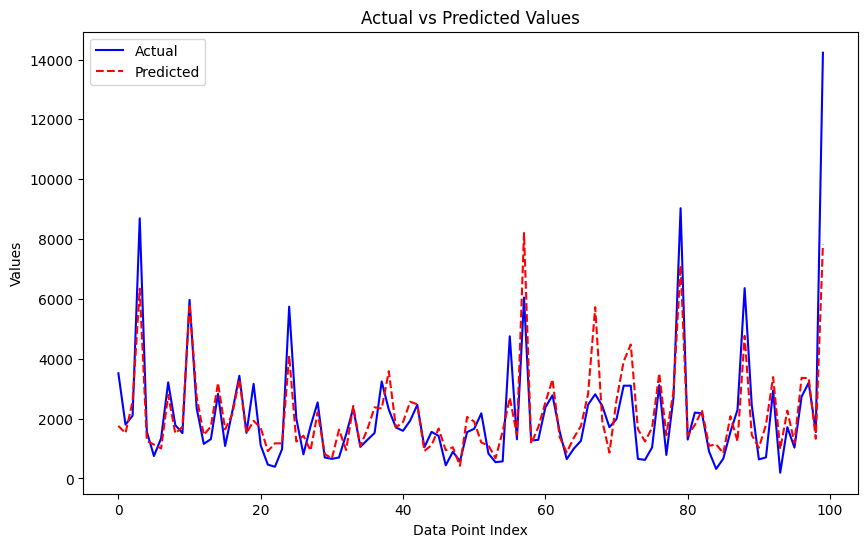

In [26]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load("best_model.pth"))
# 모델 평가 코드
model.eval()
with torch.no_grad():
    X_valid, y_valid = X_valid.to(device), y_valid.to(device)  # 검증 데이터도 GPU로 이동
    predictions = model(X_valid)
    loss = criterion(predictions, y_valid)
    print(f'평가 손실 Loss: {loss.item():.4f}')
    print(f"예측 값: {predictions[:5].view(-1).tolist()}")
    print(f"실제 값: {y_valid[:5].view(-1).tolist()}")

    # 예측 값과 실제 값 선형 그래프 그리기
    predictions_np = predictions.cpu().numpy()  # GPU에서 계산된 예측값을 CPU로 이동 후 numpy 배열로 변환
    y_valid_np = y_valid.cpu().numpy()  # 실제 값도 GPU에서 CPU로 이동 후 numpy 배열로 변환

    # 선형 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(y_valid_np[:100], label='Actual', color='blue')  # 실제 값
    plt.plot(predictions_np[:100], label='Predicted', color='red', linestyle='dashed')  # 예측 값
    plt.xlabel('Data Point Index')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

In [27]:
# 1. 모델 불러오기
model = DNNRegression()  # DNNRegression은 이전에 정의한 모델 클래스
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


X_test = df_test.values  # 예측하려는 y 값('전력사용량(kWh)')은 제외
scaler = StandardScaler()

# X_test의 첫 번째와 마지막 열을 제외한 나머지 열에 대해 스케일링
X_test[:, 1:-1] = scaler.fit_transform(X_test[:, 1:-1])

# 3. 데이터를 텐서로 변환 (torch tensor로 변환)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


with torch.no_grad():  # 학습이 아닌 예측이므로 no_grad()를 사용
    model = model.to(device)
    X_test_tensor = X_test_tensor.to(device)  # GPU 사용시 GPU로 이동
    predictions = model(X_test_tensor)  # 예측 수행

# 5. 결과 출력
predictions = predictions.cpu().numpy()  # GPU에서 CPU로 이동하고 numpy로 변환
print(f"예측 값: {predictions}")



예측 값: [[11132.5205]
 [11129.839 ]
 [11127.147 ]
 ...
 [ 1128.9479]
 [ 1128.9479]
 [ 1128.9479]]


<ipython-input-27-2df1efdc316e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
